## Plan
1. Rewrite in keras - we already bucketing sequences
2. Use an embedding layer to get drug code vectors.
3. Get drug code tree thingy.
4. Use rolling diagnosis to improve model

In [1]:
#%%time
#lets use the drug code
import marshal, gzip
pt_by_len = marshal.load(open('train_comprehensive_ptbylen.m', 'rb'))
pred_by_len = marshal.load(open('pred_comprehensive_pts.m', 'rb'))

def get_maxes():
    hidden_max = [-1000.0] * 5
    input_max = [-1000.0] * 12
    for b in pt_by_len:
        for hidden, inp, label in pt_by_len[b]:
            for i, v in enumerate(hidden):
                hidden_max[i] = max(hidden_max[i], v)
            for inp_i in inp:
                for i, v in enumerate(inp_i):
                    input_max[i] = max(input_max[i], v)
    print hidden_max
    print input_max
hidden_max = [1.0, 1.0, 1.0, 1.0, 2526]
input_max = [0.997, 1.0, 4039, 6880.7, 1041874.5, 11682.85, 1, 6, 60258, 3182, 2869, 12] #must add 1!!!


In [2]:
import random
from sklearn.model_selection import train_test_split
import numpy as np

random.seed(42)
np.random.seed(42)

def shuffle(length_arr):
    train_pt_by_len = {}
    test_pt_by_len = {}
    for length in length_arr:
        if len(length_arr[length]) >= 50:
            train_pt_by_len[length], test_pt_by_len[length] = train_test_split(pt_by_len[length], test_size=0.1, random_state=42)
    
    return train_pt_by_len, test_pt_by_len

train_pt_by_len, test_pt_by_len = shuffle(pt_by_len)
bucketlengths = {}
total = 0
for b in train_pt_by_len:
    bucketlengths[len(train_pt_by_len[b][0][1])] = len(train_pt_by_len[b])
    total += len(train_pt_by_len[b])  

def prepare_input(batch):
    batch = zip(*batch)
    
    hidden = np.array(batch[0])
    hidden = np.delete(hidden, (4,),1) # something sex sex age code
    hidden[:,3][hidden[:,3] == 1.0] = 0.5577 
    
    inp = np.array([l[1:] for l in batch[1]])
    inp = np.delete(inp ,range(2,9), 2) # now with post code
    
    
    labels = np.array(batch[2])
    return hidden, inp, labels
    

def random_batch(batch_size=1):
    chunk_len = np.random.choice(bucketlengths.keys(), 1, p=np.array(bucketlengths.values())/float(sum(bucketlengths.values())))[0]
    bucket = np.array(train_pt_by_len[chunk_len])    
    hidden, inp, labels = prepare_input(bucket[np.random.choice(bucket.shape[0], batch_size)])
    
    return hidden, inp, labels

test_bucketlengths = {}
test_total = 0
for b in test_pt_by_len:
    test_bucketlengths[len(test_pt_by_len[b][0][1])] = len(test_pt_by_len[b])
    test_total += len(test_pt_by_len[b])

def random_test_batch(batch_size=1):
    chunk_len = np.random.choice(test_bucketlengths.keys(), 1, p=np.array(test_bucketlengths.values())/float(sum(test_bucketlengths.values())))[0]
    bucket = np.array(test_pt_by_len[chunk_len])    
    hidden, inp, labels = prepare_input(bucket[np.random.choice(bucket.shape[0], batch_size)])
    
    return hidden, inp, labels

print total, test_total

245794 27453


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
import numpy as np
from sklearn.metrics import roc_auc_score
import os

def torchify_batch(hidden, inp, target=None):
    drugs = inp[:, :, -2]
    dxs = inp[:, :, -1]
    posts = inp[:,:,-3]
    inp = inp[:, :, :-3]
    hidden = np.repeat(hidden[:,np.newaxis, :], repeats=inp.shape[1], axis=1)
    
    inp = Variable(torch.from_numpy(inp), requires_grad=False)
    posts = Variable(torch.from_numpy(posts), requires_grad=False).long()
    drugs = Variable(torch.from_numpy(drugs), requires_grad=False).long()
    dxs = Variable(torch.from_numpy(dxs), requires_grad=False).long()
    hidden = Variable(torch.from_numpy(hidden), requires_grad=False)
    if target is not None:
        target = Variable(torch.from_numpy(target), requires_grad=False).long()
    
    return hidden, inp, posts, drugs, dxs, target

def train(chkpoint, epochs, model, criterion, optimizer, train_losses, test_losses, test_aucs, cur_epoch=0, **kwargs):
    total = 245794
    for epoch in xrange(cur_epoch+1, epochs+1):
        print('---Epoch {}---'.format(epoch))
        num_cycles = total / 40
        num_cycles /= 2
        for cycle in tqdm_notebook(xrange(num_cycles)):
            hidden, inp, target = random_batch(10)
            hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
            target.cuda()
            optimizer.zero_grad()
            out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())
            loss = criterion(out, target.cuda())
            loss.backward()
            optimizer.step()
        loss_var = loss.data.cpu().numpy()[0]

        total_test_auc = 0
        total_test_loss = 0

        
        batch_aucs = []
        #bootstrap = [validate(model) for _ in range(10)]
        #aucs = np.array([x[1] for x in bootstrap])
        #tests = np.array([x[0] for x in bootstrap])
        all_test_loss, all_test_auc = validate_all(model)

        #test_loss = total_test_loss/100.0
        #test_loss, test_loss_std = np.mean(tests), np.std(tests)
        #test_auc, test_auc_std = np.mean(aucs), np.std(aucs)

        train_losses.append(loss_var)
        test_losses.append(all_test_loss)
        test_aucs.append(all_test_auc)
        
        if not os.path.exists(chkpoint[:-4]):
            os.mkdir(chkpoint[:-4])

        torch.save({
                'cur_epoch': epoch,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'model': model,
                'criterion': criterion,
                'optimizer': optimizer,
                'test_aucs': test_aucs,
            }, '{}/epoch-{}-{}.tar'.format(chkpoint[:-4], epoch, int(all_test_auc * 1000)))
        
        

        print('Train Loss: {}'.format(loss_var)) # pass arguments to affect saving / resume behaviour
        #print('Test Loss: {} Std: {}'.format(test_loss, test_loss_std))
        #print('Test AUC: {} Std: {}'.format(test_auc, test_auc_std))
        print('All Test Loss: {} AUC: {}'.format(all_test_loss, all_test_auc))
        

def validate_all(model):
    all_true = np.zeros((test_total, 2))
    all_pred = np.zeros((test_total, 2))
    total_test_loss = 0
    i = 0
    for b in test_pt_by_len:
        hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(target2.shape[0]):
            all_true[i, int(target2[j])] = 1
            all_pred[i] = out_np[j]
            i += 1
        total_test_loss += loss.data.cpu().numpy()[0]
    test_loss = total_test_loss/288
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc

def validate(model):
    total_test_loss = 0
    all_true = np.zeros((4000, 2))
    all_pred = np.zeros((4000, 2))
    for i in xrange(100):
        hidden, inp, target = random_test_batch(40)
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(40):
            all_true[i*40 + j, int(target2[j])] = 1
            all_pred[i*40+j] = out_np[j]
        total_test_loss += loss.data.cpu().numpy()[0]

    test_loss = total_test_loss/100.0
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc
    

def generate_predictions_csv(model, filename):
    predictions = []
    for b in tqdm_notebook(pred_by_len):
        hidden, inp, pt_id = prepare_input(pred_by_len[b])
        hidden, inp, posts, drugs, dxs, _ = torchify_batch(hidden, inp)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda()).data.cpu().numpy()
        predictions.extend(zip(pt_id, out[:,1]))

    predictions.sort()
    with open(filename, 'w') as f:
        f.write('Patient_ID,Diabetes\n')
        for a, b in predictions:
            f.write('{},{}\n'.format(a,b))

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.post_embedding = nn.Embedding(3182, 2)
        self.drug_embedding = nn.Embedding(2870, 20)#changed from 30
        #self.inp_embedding = nn.Embedding(2, 10)
        self.dx_embedding = nn.Embedding(12, 7) #changed from 5 to 7
        self.gru1 = nn.GRU(35, 96, 4, batch_first=True,dropout=0.2)
        self.dense1 = nn.Linear(96, 2)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, hidden, inp, posts, drugs, dxs):
        posts_e = self.post_embedding(posts)
        drugs_e = self.drug_embedding(drugs)
        dxs_e = self.dx_embedding(dxs)
        #inp_e = self.inp_embedding(inp)
        final_input = torch.cat((hidden, inp, posts_e, drugs_e, dxs_e),dim=2)
    
        h_1 = Variable(torch.zeros(4,inp.size(0), 96).double(), requires_grad=False).cuda()
        output, h_2 = self.gru1(final_input, h_1)

        x = self.dense1(h_2[-1])
        x = self.softmax(x)
        
        return x

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.post_embedding = nn.Embedding(3182, 2)
        self.drug_embedding = nn.Embedding(2870, 20)#changed from 30
        #self.inp_embedding = nn.Embedding(2, 10)
        self.dx_embedding = nn.Embedding(12, 7) #changed from 5 to 7
        self.gru1 = nn.GRU(35, 96, 4, batch_first=True,dropout=0.2)
        self.dense1 = nn.Linear(96, 2)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, hidden, inp, posts, drugs, dxs):
        posts_e = self.post_embedding(posts)
        drugs_e = self.drug_embedding(drugs)
        dxs_e = self.dx_embedding(dxs)
        #inp_e = self.inp_embedding(inp)
        final_input = torch.cat((hidden, inp, posts_e, drugs_e, dxs_e),dim=2)
    
        h_1 = Variable(torch.zeros(4,inp.size(0), 96).double(), requires_grad=False).cuda()
        output, h_2 = self.gru1(final_input, h_1)

        x = self.dense1(h_2[-1])
        x = self.softmax(x)
        
        return x


#np.random.seed(42) # new seed
#torch.manual_seed(42)

model = Model1()
model.double()
model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
train_losses = []
test_losses = []
test_aucs = []

train(chkpoint='model17_post9_4_96_lr_0001.tar', 
      epochs=300, 
      model=model, 
      optimizer=optimizer, 
      criterion=criterion, 
      test_losses=test_losses,
     train_losses=train_losses,
     test_aucs=test_aucs)

---Epoch 1---



Train Loss: 0.0254803099756
All Test Loss: 0.19576329119 AUC: 0.951423801387
---Epoch 2---



Train Loss: 0.0245366807296
All Test Loss: 0.161425788486 AUC: 0.958323547113
---Epoch 3---



Train Loss: 0.176811447575
All Test Loss: 0.154061450668 AUC: 0.96129459076
---Epoch 4---



Train Loss: 0.139227078605
All Test Loss: 0.152362023483 AUC: 0.961509349889
---Epoch 5---



Train Loss: 0.411345461107
All Test Loss: 0.155256215859 AUC: 0.962709229702
---Epoch 6---



Train Loss: 0.171678976367
All Test Loss: 0.148451783452 AUC: 0.963225926552
---Epoch 7---



Train Loss: 0.0334983584196
All Test Loss: 0.153010733751 AUC: 0.964304548633
---Epoch 8---



Train Loss: 0.452200215326
All Test Loss: 0.148272181206 AUC: 0.962920304132
---Epoch 9---



Train Loss: 0.336839195964
All Test Loss: 0.145948184742 AUC: 0.963634841634
---Epoch 10---



Train Loss: 0.111368793041
All Test Loss: 0.145168137777 AUC: 0.964518460108
---Epoch 11---



Train Loss: 0.0654398232088
All Test Loss: 0.144487192772 AUC: 0.964404580423
---Epoch 12---



Train Loss: 0.0124485474315
All Test Loss: 0.143987867459 AUC: 0.964429958138
---Epoch 13---



Train Loss: 0.0117764510252
All Test Loss: 0.143933041373 AUC: 0.96420766527
---Epoch 14---



Train Loss: 0.245893806343
All Test Loss: 0.142107280121 AUC: 0.964942883794
---Epoch 15---



Train Loss: 0.0331036429638
All Test Loss: 0.142770702788 AUC: 0.965062610559
---Epoch 16---



Train Loss: 0.168224077712
All Test Loss: 0.145727886971 AUC: 0.965072583465
---Epoch 17---



Train Loss: 0.0320875851985
All Test Loss: 0.144114329143 AUC: 0.964893131709
---Epoch 18---



Train Loss: 0.470876915236
All Test Loss: 0.140383965737 AUC: 0.966068213326
---Epoch 19---



Train Loss: 0.442898152727
All Test Loss: 0.143962507572 AUC: 0.965835912954
---Epoch 20---



Train Loss: 0.439247538176
All Test Loss: 0.139042687665 AUC: 0.965757556881
---Epoch 21---



Train Loss: 0.0306171698938
All Test Loss: 0.139629196815 AUC: 0.96656082989
---Epoch 22---



Train Loss: 0.453348241695
All Test Loss: 0.140140373961 AUC: 0.965696759349
---Epoch 23---



Train Loss: 0.115264795321
All Test Loss: 0.140098124604 AUC: 0.965493677083
---Epoch 24---



Train Loss: 0.0198815693058
All Test Loss: 0.139922690354 AUC: 0.965762686051
---Epoch 25---



Train Loss: 0.544957226886
All Test Loss: 0.138936136943 AUC: 0.966326124949
---Epoch 26---



Train Loss: 0.0131888164126
All Test Loss: 0.139777371821 AUC: 0.96649046598
---Epoch 27---



Train Loss: 0.0553513990081
All Test Loss: 0.137772964323 AUC: 0.967153512842
---Epoch 28---



Train Loss: 0.0471236004428
All Test Loss: 0.138961425722 AUC: 0.966830833553
---Epoch 29---



Train Loss: 0.0150388183141
All Test Loss: 0.139379353837 AUC: 0.966410258908
---Epoch 30---



Train Loss: 0.034301000832
All Test Loss: 0.139863266184 AUC: 0.96727722704
---Epoch 31---



Train Loss: 0.41602470267
All Test Loss: 0.137387094625 AUC: 0.966869479644
---Epoch 32---



Train Loss: 0.0459748328306
All Test Loss: 0.138406451188 AUC: 0.967314705445
---Epoch 33---



Train Loss: 0.0647458239823
All Test Loss: 0.138266111205 AUC: 0.966602287077
---Epoch 34---



Train Loss: 0.176307069079
All Test Loss: 0.137719313689 AUC: 0.966345456644
---Epoch 35---



Train Loss: 0.0128249388871
All Test Loss: 0.143890371387 AUC: 0.966514745205
---Epoch 36---



Train Loss: 0.159758409142
All Test Loss: 0.137715176753 AUC: 0.966926670323
---Epoch 37---



Train Loss: 0.0142506633789
All Test Loss: 0.136986634061 AUC: 0.966447252938
---Epoch 38---



Train Loss: 0.0973869122201
All Test Loss: 0.140085417311 AUC: 0.967083633306
---Epoch 39---



Train Loss: 0.176344474033
All Test Loss: 0.136560732767 AUC: 0.967390605052
---Epoch 40---



Train Loss: 0.0121109514848
All Test Loss: 0.139018802869 AUC: 0.9665459873
---Epoch 41---



Train Loss: 0.0744845238302
All Test Loss: 0.137193989743 AUC: 0.966409099871
---Epoch 42---



Train Loss: 0.334501609686
All Test Loss: 0.136626018957 AUC: 0.966580447019
---Epoch 43---



Train Loss: 0.140259403323
All Test Loss: 0.139924110032 AUC: 0.967390985632
---Epoch 44---



Train Loss: 0.423780337383
All Test Loss: 0.140794736566 AUC: 0.967103155291
---Epoch 45---



Train Loss: 0.01271108869
All Test Loss: 0.138568907567 AUC: 0.966996480663
---Epoch 46---



Train Loss: 0.0406268289811
All Test Loss: 0.138345101038 AUC: 0.967562211686
---Epoch 47---



Train Loss: 0.0135938390111
All Test Loss: 0.13832479059 AUC: 0.96728896445
---Epoch 48---



Train Loss: 0.0173319892253
All Test Loss: 0.137412427318 AUC: 0.967030923083
---Epoch 49---



Train Loss: 0.0612885165286
All Test Loss: 0.137122390331 AUC: 0.967358342313
---Epoch 50---



Train Loss: 0.0194290433141
All Test Loss: 0.146653382155 AUC: 0.966951875047
---Epoch 51---



Train Loss: 0.0643155795751
All Test Loss: 0.138523044586 AUC: 0.96718506632
---Epoch 52---



Train Loss: 0.0187965774866
All Test Loss: 0.137822748159 AUC: 0.966778633652
---Epoch 53---



Train Loss: 0.0105518460369
All Test Loss: 0.137311165826 AUC: 0.967316236411
---Epoch 54---



Train Loss: 0.122968971771
All Test Loss: 0.138177437643 AUC: 0.96713925842
---Epoch 55---



Train Loss: 0.0983925235828
All Test Loss: 0.1369502446 AUC: 0.967519690607
---Epoch 56---



Train Loss: 0.0170401313792
All Test Loss: 0.137746413962 AUC: 0.967471979811
---Epoch 57---



Train Loss: 0.473229725084
All Test Loss: 0.137404783949 AUC: 0.967349934972
---Epoch 58---



Train Loss: 0.0605711003363
All Test Loss: 0.136964501155 AUC: 0.966998617096
---Epoch 59---



Train Loss: 0.0242826851465
All Test Loss: 0.140103602689 AUC: 0.96759017561
---Epoch 60---



Train Loss: 0.0175708961795
All Test Loss: 0.139123766914 AUC: 0.966939350531
---Epoch 61---



Train Loss: 0.0977246425017
All Test Loss: 0.136957307015 AUC: 0.967478034481
---Epoch 62---



Train Loss: 0.046394925127
All Test Loss: 0.140236292795 AUC: 0.966757321216
---Epoch 63---



Train Loss: 0.0167075908689
All Test Loss: 0.137265494882 AUC: 0.96757827386
---Epoch 64---


In [ ]:
data_dict = torch.load('model10_post9_3_64_lr_001/epoch-2-963.tar')
#data_dict['optimizer'] = torch.optim.Adam(model.parameters(), lr=0.0003)
#data_dict['optimizer'] = torch.optim.SGD(model.parameters(), lr=0.001, momentum=1.3, nesterov=True)
train(chkpoint='model10_post9_3_64_lr_001.tar', epochs=30, **data_dict)

In [12]:
data_dict = torch.load('model15_post9_4_64_lr_0001/epoch-18-966.tar')
train(chkpoint='model15_post9_4_64_lr_0001.tar', epochs=200, **data_dict)

---Epoch 19---



Train Loss: 0.0882221857078
All Test Loss: 0.137210664155 AUC: 0.966882912361
---Epoch 20---



Train Loss: 0.187242742521
All Test Loss: 0.141372579546 AUC: 0.965857830858
---Epoch 21---



Train Loss: 0.0842310044231
All Test Loss: 0.140310185558 AUC: 0.966894770864
---Epoch 22---



Train Loss: 0.0407696297891
All Test Loss: 0.140559540034 AUC: 0.966555034706
---Epoch 23---



Train Loss: 0.0192146036612
All Test Loss: 0.140120922814 AUC: 0.966307191133
---Epoch 24---



Train Loss: 0.374695956372
All Test Loss: 0.13882760964 AUC: 0.966562092721
---Epoch 25---



Train Loss: 0.0162339988752
All Test Loss: 0.144060908465 AUC: 0.967039373672
---Epoch 26---



Train Loss: 0.468255587505
All Test Loss: 0.138188695435 AUC: 0.966005495599
---Epoch 27---



Train Loss: 0.0333150666509
All Test Loss: 0.138592460651 AUC: 0.966949565623
---Epoch 28---


KeyboardInterrupt: 

In [71]:
%%time
aucs = np.array([validate(model)[1] for x in range(10)])
print np.mean(aucs), np.std(aucs)


0.958957016353 0.00762216388464
CPU times: user 19.3 s, sys: 565 ms, total: 19.8 s
Wall time: 19.8 s


In [21]:
data_dict = torch.load('model11_post9_4_64_lr_001/epoch-19-965.tar')
generate_predictions_csv(data_dict['model'], 'out-log-softmax-965.csv')

## Exploring where the mistakes are coming from

In [43]:
all_true = np.zeros((test_total))
all_pred = np.zeros((test_total))

bad_answers = []

total_test_loss = 0
i = 0
for b in test_pt_by_len:
    hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
    target2 = target[:]
    hidden2 = hidden[:]
    inp2 = inp[:]
    hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
    out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

    target.cuda()

    loss = criterion(out, target.cuda())
    out_np = out.data.cpu().numpy()
    for j in xrange(target2.shape[0]):
        all_true[i] = int(target2[j])
        all_pred[i] = out_np[j][1]
        if abs(all_true[i] - all_pred[i]) > 0.99:
            bad_answers.append((target2[j], hidden2[j], inp2[j]))
        i += 1
    total_test_loss += loss.data.cpu().numpy()[0]
test_loss = total_test_loss/288
test_auc = roc_auc_score(all_true, all_pred)

In [60]:
uros = 0
for target, hidden, transaction in bad_answers:
    uros += (np.sum(transaction[:, 4] == 11) > 0)
print uros

802


In [62]:
802.0 / test_total * total

7180.51899610243

In [13]:
error = all_true - all_pred

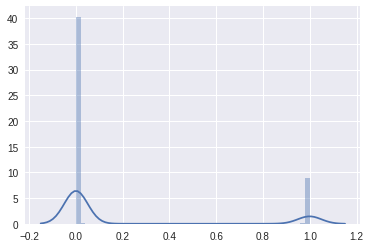

In [31]:
sns.distplot(all_pred)

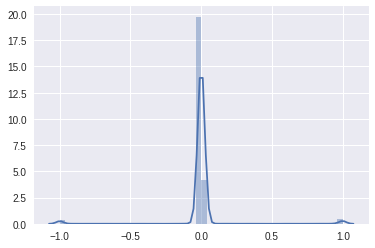

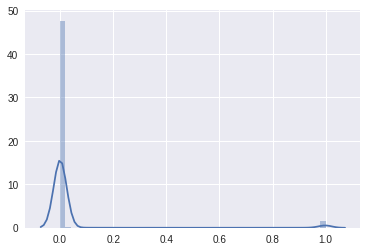

In [18]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(error)
plt.show()
sns.distplot(np.abs(error))

In [34]:
print np.sum(np.abs(error) > 0.01) 1354
print np.sum(np.abs(error) > 0.99) 864
print 861.0/test_total

1354
861
0.0313626926019


In [ ]:
np.abs(error) > 0.99

In [35]:
test_total

27453

In [73]:
generate_predictions_csv(model, 'out1.csv')

In [ ]:
train('model_post1.1_3_32_lr_001.tar', epochs=10, **torch.load('model_post1_3_32_lr_001.tar'))

---Epoch 8---


In [80]:
torch.load('model_3_32_lr_001.tar')

{'criterion': CrossEntropyLoss (
 ), 'cur_epoch': 4, 'model': Model1 (
   (drug_embedding): Embedding(2870, 30)
   (dx_embedding): Embedding(12, 5)
   (gru1): GRU(39, 32, num_layers=3, batch_first=True)
   (dense1): Linear (32 -> 2)
   (softmax): Softmax ()
 ), 'optimizer': <torch.optim.adam.Adam at 0x7f23016a2350>, 'test_aucs': [0.9497745120551091,
  0.95737772101378837,
  0.96352282510260245,
  0.97322535701846047], 'test_losses': [0.35393751389666983,
  0.35761409787089349,
  0.35281944691292533,
  0.34829183176775053], 'train_losses': [0.37126914617345386,
  0.33828777079089706,
  0.33836713117440947,
  0.39558140579214862]}

In [12]:
def validate_all(model):
    all_true = np.zeros((test_total, 2))
    all_pred = np.zeros((test_total, 2))
    total_test_loss = 0
    i = 0
    for b in tqdm_notebook(test_pt_by_len):
        hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(target2.shape[0]):
            all_true[i, int(target2[j])] = 1
            all_pred[i] = out_np[j]
            i += 1
        total_test_loss += loss.data.cpu().numpy()[0]
    test_loss = total_test_loss/288
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc

validate_all(model)

Widget Javascript not detected.  It may not be installed or enabled properly.


(0.35821641802842302, 0.94314307203172887)

In [7]:
test_total

27453